In [1]:
import gym
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from collections import deque
from datetime import datetime
from matplotlib import pyplot as plt

# from assignment3_utils import process_frame
from pong_utils import img_crop, downsample, to_grayscale, normalize_grayscale

In [2]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

In [3]:
# %load_ext tensorboard

In [4]:
INPUT_SHAPE = (84, 80, 4)

### Preprocessing and Stacking

In [5]:
def process_frame(img, image_shape):
    img = img_crop(img)
    img = downsample(img)    # Crop and downsize (by 2)
    img = to_grayscale(img)       # Convert to greyscale by averaging the RGB values
    img = normalize_grayscale(img)  # Normalize from -1 to 1.
    
    return img.reshape(image_shape[0], image_shape[1], 1)

In [6]:
def stack_frames(stack, new_frame, stack_size=4, is_new=False):

    processed_frame = process_frame(new_frame, image_shape=(84, 80))

    if is_new or not stack:
        stack = deque([processed_frame] * stack_size, maxlen=stack_size)
    else:
        stack.append(processed_frame)

    # Make sure the stack is exactly 'stack_size' frames by repeating the last frame if necessary
    while len(stack) < stack_size:
        stack.append(processed_frame)

    stacked_frames = np.concatenate([np.expand_dims(frame, axis=-1) for frame in stack], axis=-1)
    return stacked_frames

#### Check Preprocessing

frame.shape=(210, 160, 3)
processed_frame.shape=(84, 80, 1)
expanded_frame.shape=(1, 84, 80, 1)


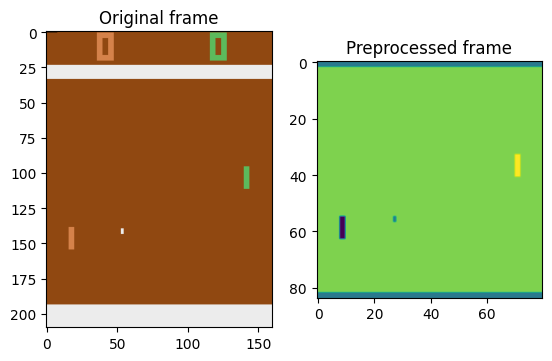

In [7]:
env = gym.make('PongDeterministic-v4')
env.reset()

_, _, _, _, _ = env.step(0)
for _ in range(20):
    frame, _, _, _, _ = env.step(1)
print(f'{frame.shape=}')

plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title('Original frame')

plt.subplot(1, 2, 2)
processed_frame = process_frame(frame, INPUT_SHAPE[:-1])
print(f'{processed_frame.shape=}')
expanded_frame = np.expand_dims(processed_frame, axis=0)
print(f'{expanded_frame.shape=}')
plt.imshow(expanded_frame[0])
plt.title('Preprocessed frame')

plt.show()

### DQN Agent 

In [8]:
class ReplayBuffer:
    def __init__(self, capacity, minibatch_size) -> None:
        self.buffer = deque(maxlen=capacity)
        self.minibatch_size = minibatch_size
    
    def push(self, state, action, reward, next_state, done):
        if state.shape != (84, 80, 1, 4) or next_state.shape != (84, 80, 1, 4):
            # print(f'shape is mismatching {state.shape=}\t{next_state.shape=}')
            return
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*samples))
        return states, actions, rewards, next_states, dones
   
    def __len__(self):
        return len(self.buffer)

In [9]:
class Agent:
    def __init__(
            self, env, policy_net, target_net, 
            batch_size=32, lr=1e-4, gamma=0.95, epsilon_init=1.0, epsilon_min=0.05, epsilon_decay=0.995,
            replay_buffer_capacity=10000, initialize_replay_buffer=False,
            steps_to_update_epsilon=500, skip_frames=3, skip_start=20
    ) -> None:
        self.env = env
        # self.replay_buffer = replay_buffer
        self.policy_net = policy_net
        self.target_net = target_net
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_init
        self.epsilon_start = epsilon_init
        self.epsilon_final = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.skip_start = skip_start
        self.steps_to_update_epsilon = steps_to_update_epsilon
        self.skip_frames = skip_frames
        
        self.optimizer = tf.optimizers.Adam(lr)
        self.stacked_states = deque([], maxlen=4)
        self.state = None
        self.num_steps = 0

        self.replay_buffer = ReplayBuffer(replay_buffer_capacity, batch_size)
        if initialize_replay_buffer:
            self.populate_initial_replay_buffer(env, initial_fill=replay_buffer_capacity)

        self.update_target_net()

    def populate_initial_replay_buffer(self, env, initial_fill=10000, stack_size=4):
        state = env.reset()[0]
        state = stack_frames(None, state, stack_size=stack_size, is_new=True)
        for _ in range(initial_fill):
            action = env.action_space.sample()  # Take a random action
            next_state, reward, done, _, _ = env.step(action)
            next_state = stack_frames(self.stacked_states, next_state, stack_size=stack_size)
            self.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state if not done else env.reset()[0]

    def select_action(self, state):
        self.num_steps += 1
        if self.num_steps % self.steps_to_update_epsilon == 0:
            # self.epsilon -= (self.epsilon_start - self.epsilon_final) / self.epsilon_decay
            self.epsilon *= self.epsilon_decay
            self.epsilon = self.epsilon_final if self.epsilon < self.epsilon_final else self.epsilon

        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        else:
            state_tensor = tf.convert_to_tensor(state.reshape(1, 84, 80, 4), dtype=tf.float32)  # Reshape to add batch dimension
            q_values = self.policy_net(state_tensor)
            return np.argmax(q_values.numpy()[0])
    
    def step(self, action):
        total_reward, done = 0, None
        for _ in range(self.skip_frames):
            # Skipping frames by repeating the same action for self.skip_frames times
            next_state, reward, done, _, _ = self.env.step(action)
            total_reward += reward
            if done:
                break
        next_state_stacked = stack_frames(self.stacked_states, next_state)
        self.replay_buffer.push(self.state, action, total_reward, next_state_stacked, done)
        self.state = next_state_stacked
        return total_reward, done
    
    def optimize_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = np.squeeze(states, axis=-2)
        next_states = np.squeeze(next_states, axis=-2)

        masks = tf.one_hot(actions, self.policy_net.output.shape[-1])
        with tf.GradientTape() as tape:
            q_values = self.policy_net(states)
            q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            future_q_values = self.target_net(next_states)
            updated_q_values = rewards + self.gamma * tf.reduce_max(future_q_values, axis=1) * (1 - dones)
            loss = tf.keras.losses.mean_squared_error(updated_q_values, q_actions)
        
        grads = tape.gradient(loss, self.policy_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy_net.trainable_variables))

        return loss
    
    def update_target_net(self):
        self.target_net.set_weights(self.policy_net.get_weights())
    
    def reset(self):
        state, _ = self.env.reset()
        for _ in range(self.skip_start):
            state, _, _, _, _ = self.env.step(0)
        
        self.stacked_states = deque([], maxlen=4)
        self.state = stack_frames(self.stacked_states, state, is_new=True)


### Model

In [10]:
def build_model(input_shape, num_actions):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_actions, activation='linear'))

    model.compile(loss='huber_loss', optimizer=Adam(learning_rate=1e-4))

    return model

### Simulation

In [11]:
import time
from IPython import display

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title(f'Step: {step} {info}')
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

def play(env, model, target_model, max_steps=1000, wait_time=0.05):
    _ = env.reset()
    rl_agent = Agent(env, model, target_model)
    rl_agent.reset()
    episode_reward = 0
    tot_time = 0
    for step in range(max_steps):
        state_tensor = tf.convert_to_tensor(rl_agent.state.reshape(1, 84, 80, 4), dtype=tf.float32)  # Reshape to add batch dimension
        q_values = rl_agent.policy_net(state_tensor)
        action = np.argmax(q_values.numpy()[0])
        reward, done = rl_agent.step(action)
        episode_reward += reward
        show_state(env, step, f' |  Reward: {episode_reward}')
        time.sleep(wait_time)
        if done:
            print(f'Game score: {episode_reward}\tSteps: {step}')
            break
        
 

### Game of an empty model

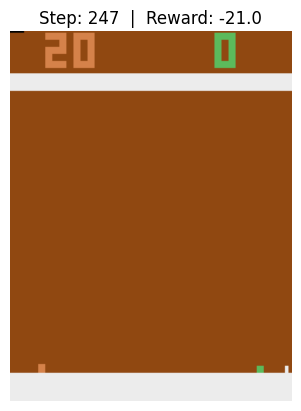

Game score: -21.0	Steps: 247


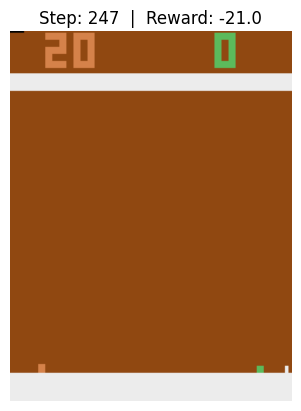

In [12]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')

policy_net = build_model(INPUT_SHAPE, env.action_space.n)
target_net = build_model(INPUT_SHAPE, env.action_space.n)

play(env, policy_net, target_net)

### Training

In [13]:
def train(
        env, policy_net, target_net, episodes=100, batch_size=8, target_update_freq=10, max_steps_per_episode=1000, 
        model_name_prefix='', skip_frames=3
):
    st = datetime.now()
    if model_name_prefix and not model_name_prefix.endswith('_'):
        model_name_prefix += '_'
    model_file_prefix = 'models/' + model_name_prefix # Add folder name before prefix
    log_dir = 'logs/Pong_' + model_name_prefix + st.strftime("%b%d_%H%M%S")
    summary_writer = tf.summary.create_file_writer(log_dir)
    print(f'Training Started at {st}')

    agent = Agent(env, policy_net, target_net, batch_size=batch_size, skip_frames=skip_frames, initialize_replay_buffer=True)

    episode_rewards = []
    episode_loss = []
    metrics = []

    for episode in range(episodes):
        # print(f'Episode: {episode}')
        est = datetime.now()
        loss = None
        agent.reset()
        episode_reward = 0
        done = False
        for step in range(max_steps_per_episode):
            # print(f'Step: {step}')
            action = agent.select_action(agent.state)
            reward, done = agent.step(action)
            episode_reward += reward
            if done:
                break

            loss = agent.optimize_model()
            if loss is not None:
                episode_loss.append(loss)
        
        episode_rewards.append(episode_reward)
        avg_last_5_rewards = np.mean(episode_rewards if episode <= 5 else episode_rewards[-5:])
        average_loss = np.mean(episode_loss) if episode_loss else 0

        if episode % target_update_freq == 0:
            agent.update_target_net()
        
        with summary_writer.as_default():
            tf.summary.scalar('Total Reward', episode_reward, step=episode)
            tf.summary.scalar('Average Rewards (Last 5 Episodes)', avg_last_5_rewards, step=episode)
            tf.summary.scalar('Average Loss', average_loss, step=episode)
            tf.summary.scalar('Epsilon', agent.epsilon, step=episode)

        summary_writer.flush()
        
        episode_time = datetime.now() - est
        print(f'| {datetime.now()} | Episode: {episode+1:>03}/{episodes} | Episode Reward: {episode_reward} | Overall Average Reward: {np.mean(episode_rewards):.2f} | Steps: {(step+1)*skip_frames:>4} | Elapsed Time: {episode_time} |')
        metrics.append([episode, step+1, episode_reward, average_loss, agent.epsilon, episode_time])
        
        if episode % 200 == 0 and episode != 0:
            print(f'| {datetime.now()} | Saving models at {episode=}')
            policy_net.save(f'{model_file_prefix}policy_net_checkpoint_{episode}.h5', save_format='tf')
            policy_net.save_weights(f'{model_file_prefix}policy_net_weights_{episode}.ckpt')
            target_net.save(f'{model_file_prefix}target_net_checkpoint_{episode}.h5', save_format='tf')
            target_net.save_weights(f'{model_file_prefix}target_net_weights_{episode}.ckpt')
    
    env.close()
    et = datetime.now()
    df = pd.DataFrame(metrics, columns=['episode', 'total_steps', 'total_reward', 'average_loss', 'epsilon', 'elapsed_time'])
    df.to_csv(f'metrics/{model_name_prefix}{st.strftime("%b%d_%H%M%S")}_metrics.csv', index=False)
    print(f'Training completed at {et}\nElapsed Time: {et -st}')
    policy_net.save(f'{model_file_prefix}policy_net_checkpoint.h5', save_format='tf')
    policy_net.save_weights(f'{model_file_prefix}policy_net_weights.ckpt')
    target_net.save(f'{model_file_prefix}target_net_checkpoint.h5', save_format='tf')
    target_net.save_weights(f'{model_file_prefix}target_net_weights.ckpt')

    return agent

### Agent 1 
with batch_size = 8  
and target_update_freq = 10

In [26]:
policy_net = build_model(INPUT_SHAPE, env.action_space.n)
target_net = build_model(INPUT_SHAPE, env.action_space.n)

# prev_model = 'Model_2'
# policy_net.load_weights(f'models/{prev_model}_policy_net_weights_100.ckpt')
# target_net.load_weights(f'models/{prev_model}_target_net_weights_100.ckpt')

agent1 = train(
    env, policy_net, target_net, episodes=1000, 
    batch_size=8, target_update_freq=10, 
    max_steps_per_episode=2000, model_name_prefix='Agent_1'
)

Training Started at 2024-04-06 18:42:48.104049
| 2024-04-06 18:43:09.464588 | Episode: 001/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  867 | Elapsed Time: 0:00:15.435649 |
| 2024-04-06 18:43:26.503177 | Episode: 002/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  894 | Elapsed Time: 0:00:17.038589 |
| 2024-04-06 18:43:41.387092 | Episode: 003/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  765 | Elapsed Time: 0:00:14.883915 |
| 2024-04-06 18:43:56.917732 | Episode: 004/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  834 | Elapsed Time: 0:00:15.529514 |
| 2024-04-06 18:44:09.589899 | Episode: 005/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  852 | Elapsed Time: 0:00:12.672167 |
| 2024-04-06 18:44:16.248908 | Episode: 006/1000 | Episode Reward: -20.0 | Overall Average Reward: -20.83 | Steps: 1020 | Elapsed Time: 0:00:06.659009 |
| 2024-04-06 18:44:22.645308 | Epis

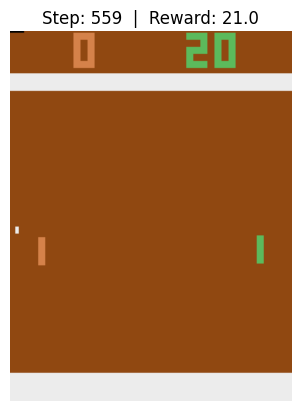

Game score: 21.0	Steps: 559


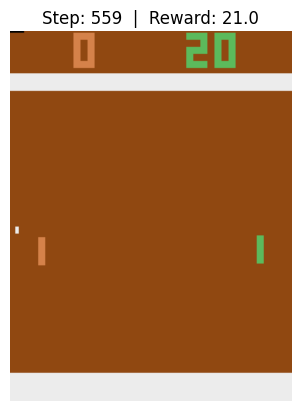

In [37]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')

play(env, agent1.policy_net, agent1.target_net)

### Agent 2 
with batch_size = 16  
and target_update_freq = 3

In [32]:
policy_net = build_model(INPUT_SHAPE, env.action_space.n)
target_net = build_model(INPUT_SHAPE, env.action_space.n)

agent2 = train(
    env, policy_net, target_net, episodes=1000, 
    batch_size=16, target_update_freq=3, 
    max_steps_per_episode=2000, model_name_prefix='Agent_2'
)

Training Started at 2024-04-07 04:13:34.935896
| 2024-04-07 04:13:50.398449 | Episode: 001/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  774 | Elapsed Time: 0:00:06.794062 |
| 2024-04-07 04:14:06.776726 | Episode: 002/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  861 | Elapsed Time: 0:00:16.377282 |
| 2024-04-07 04:14:15.855944 | Episode: 003/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps: 1047 | Elapsed Time: 0:00:09.079218 |
| 2024-04-07 04:14:39.562240 | Episode: 004/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  945 | Elapsed Time: 0:00:23.705295 |
| 2024-04-07 04:15:01.162274 | Episode: 005/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  834 | Elapsed Time: 0:00:21.599022 |
| 2024-04-07 04:15:23.640414 | Episode: 006/1000 | Episode Reward: -21.0 | Overall Average Reward: -21.00 | Steps:  834 | Elapsed Time: 0:00:22.478140 |
| 2024-04-07 04:15:31.191854 | Epis

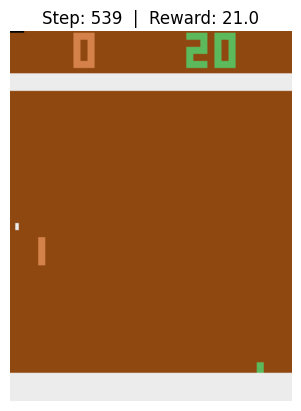

Game score: 21.0	Steps: 539


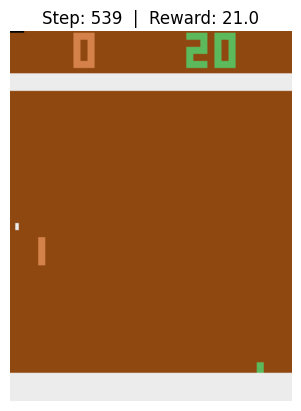

In [38]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')

play(env, agent2.policy_net, agent2.target_net)